# Fit Demo - NGC 337
------------------------------
Using the Dale et al. (2017) photometry, fit the SED of NGC 337 with a basic model.

## Imports

In [11]:
import numpy as np
import h5py
rng = np.random.default_rng()
import astropy.units as u
from astropy.table import Table
from corner import corner
import matplotlib.pyplot as plt
plt.style.use('ebm-dejavu')
%matplotlib inline

from lightning import Lightning
from lightning.priors import UniformPrior

## NGC 337
Used in the ["basic" example in the Lightning documentation](https://lightning-sed.readthedocs.io/en/latest/examples/NGC_337_example.html). Compare all the plots.

In [12]:
cat = Table.read('../photometry/ngc337_dale17_photometry.fits')

# Some annoyance with converting table columns to flat numpy arrays and text encoding:
# strings come in as bytestrings (unencoded) by default python wants UTF-8, I think.
# The labels are also padded with spaces.
filter_labels = np.array([s.decode().strip() for s in cat['FILTER_LABELS'].data[0]])
fnu_obs = cat['FNU_OBS'].data[0]
fnu_unc = cat['FNU_UNC'].data[0]
dl = cat['LUMIN_DIST'].data[0]

l = Lightning(filter_labels, 
              lum_dist=dl, 
              SFH_type='Piecewise-Constant',
              atten_type='Modified-Calzetti',
              dust_emission=True,
              model_unc=0.10,
              print_setup_time=True)

l.flux_obs = fnu_obs * 1e3
l.flux_unc = fnu_unc * 1e3

0.061 s elapsed in _get_filters
0.001 s elapsed in _get_wave_obs
0.550 s elapsed in stellar model setup
0.000 s elapsed in dust attenuation model setup
0.316 s elapsed in dust emission model setup
0.000 s elapsed in agn emission model setup
0.000 s elapsed in X-ray model setup
0.928 s elapsed total


### Fit with `emcee`

In [3]:
l.print_params(verbose=True)


Piecewise-Constant
Parameter  Lo  Hi              Description
--------- --- --- ------------------------
    psi_1 0.0 inf SFR in stellar age bin 1
    psi_2 0.0 inf SFR in stellar age bin 2
    psi_3 0.0 inf SFR in stellar age bin 3
    psi_4 0.0 inf SFR in stellar age bin 4
    psi_5 0.0 inf SFR in stellar age bin 5

Modified-Calzetti
      Parameter   Lo  Hi                                              Description
--------------- ---- --- --------------------------------------------------------
mcalz_tauV_diff  0.0 inf                         Optical depth of the diffuse ISM
    mcalz_delta -inf inf      Deviation from the Calzetti+2000 UV power law slope
  mcalz_tauV_BC  0.0 inf Optical depth of the birth cloud in star forming regions

DL07-Dust
      Parameter     Lo       Hi                                                             Description
--------------- ------ -------- -----------------------------------------------------------------------
dl07_dust_alpha  -10.0      4.0

In [13]:
p = np.array([1,1,1,1,1,
              0.3, 0.0, 0.0,
              2, 1, 3e5, 0.1, 0.01])

# Currently the setup is to provide this mask that tells
# lightning which parameters are constant
const_dim = np.array([False, False, False, False, False,
                      False, False, True,
                      True, False, True, False, False])

# This is a little tedious 
priors = [UniformPrior([0, 1e1]), # SFH
          UniformPrior([0, 1e1]),
          UniformPrior([0, 1e1]),
          UniformPrior([0, 1e1]),
          UniformPrior([0, 1e1]),
          UniformPrior([0, 3]), # tauV
          UniformPrior([-3, 3]), # delta
          None, # tauV birth cloud
          None, # alpha
          UniformPrior([0.1, 25]), # Umin
          None, # Umax
          UniformPrior([0,1]),
          UniformPrior([0.0047, 0.0458])]

var_dim = ~const_dim

Nwalkers = 64
# Starting the MCMC in a very small Gaussian ball around the above parameters
p0 = p[None, :] + rng.normal(loc=0, scale=1e-3, size=(Nwalkers, len(p)))
p0[:, const_dim] = p[const_dim]

In [14]:
# Will print a tqdm progress bar -- note that the pure models s-1 throughput
# is the number of iterations s-1 that it shows multiplied by the number of walkers.
mcmc = l.fit(p0, method='emcee', Nwalkers=Nwalkers, Nsteps=20000, priors=priors, const_dim=const_dim)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [32:11<00:00, 10.35it/s]


In [15]:
print('MCMC mean acceptance fraction: %.3f' % (np.mean(mcmc.acceptance_fraction)))
# The autocorrelation time is <= 500; emcee is gonna tell us that the esimate of the
# autocorrelation time is bad because we haven't run a long enough chain (it's right)
# so the below line is commented out
# print('MCMC mean autocorrelation time: %.1f' % (np.mean(mcmc.get_autocorr_time())))

MCMC mean acceptance fraction: 0.281


In [8]:
# # We'll thin by a factor that's overkill since our estimate of the autocorrelation time
# # may be wrong
# chain = mcmc.get_chain(discard=1000, thin=300, flat=True)
# logprob_chain = mcmc.get_log_prob(discard=1000, thin=300, flat=True)

In [23]:
# Automatically construct chopped/thinned/flattened chains
# based on the autocorrelation times of the chains, and retain the
# last 1000 samples. If we instead got a message
# here that the autocorrelation times were too long, we could:
# - Provide a manual scale for burn-in and thinning
# - Re-run the whole MCMC (expensive)
# - Simply continue the MCMC where it left off by doing mcmc.run_mcmc(None, Nsteps).
chain, logprob_chain, tau_ac = l.get_mcmc_chains(mcmc, discard=2000, thin=500, const_dim=const_dim, const_vals=p[const_dim])

         The autocorrelation estimate may be unreliable.


In [24]:
print("Autocorrelation times (not super actionable as long as they're shorter than N/50, but here they are):")
print(tau_ac)
print('Nsteps / 50 = %.2f' % (20000 / 50))

Autocorrelation times (not super actionable as long as they're shorter than N/50, but here they are):
nan
Nsteps / 50 = 400.00


In [25]:
# Checkpoints
# with open('ngc337_chains.npy', 'wb') as f:
#     np.save(f, chain)
#     np.save(f, logprob_chain)
with h5py.File('ngc337_chains.hdf5', 'w') as f:
    f.create_dataset('mcmc/samples', data=chain)
    f.create_dataset('mcmc/logprob_samples', data=logprob_chain)

In [26]:
# with open('ngc337_chains.npy', 'rb') as f:
#     chain = np.load(f)
#     logprob_chain = np.load(f)
with h5py.File('ngc337_chains.hdf5', 'r') as f:
    chain = f['mcmc/samples'][:]
    logprob_chain = f['mcmc/logprob_samples'][:]

In [28]:
# Since we passed `const_dim` and `const_vals` to `get_mcmc_chains` the
# chain here contains all the constant dimensions:
chain.shape

(1000, 13)

### Plots

Now we can visualize the results using the new builtin plotting functions. Note that each of the plotting functions looks for a Lightning object as the first argument and then the parameters (and possibly log probability chain) as the second (third) arguments. In the future these functions will probably be accessible as methods of the Lightning class, such that we could replace the below with:

`fig, axs = l.chain_plot(param_arr, color='k', alpha=0.8)`

Note that there are no `rcParams` edits made in the plotting functions, so the appearance of the plots is inherited from the matplotlib style file I loaded at the beginning.

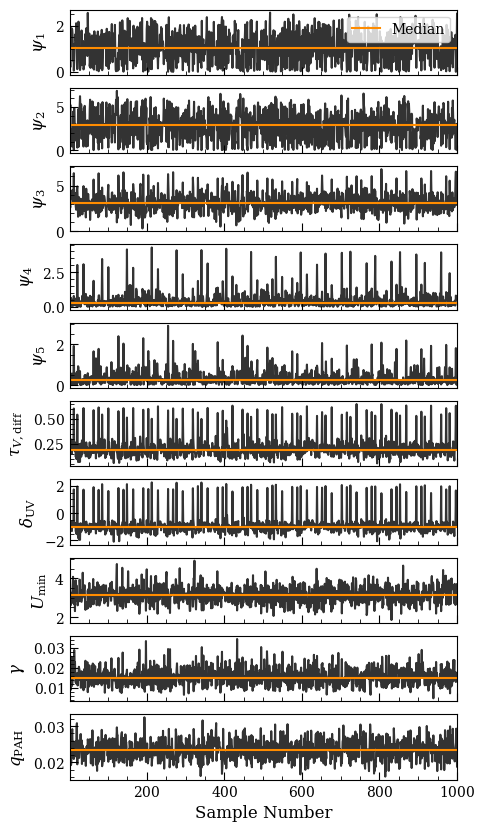

In [33]:
# from lightning.plots import chain_plot

# fig, axs = chain_plot(l, param_arr, color='k', alpha=0.8)

fig, axs = l.chain_plot(chain, color='k', alpha=0.8)

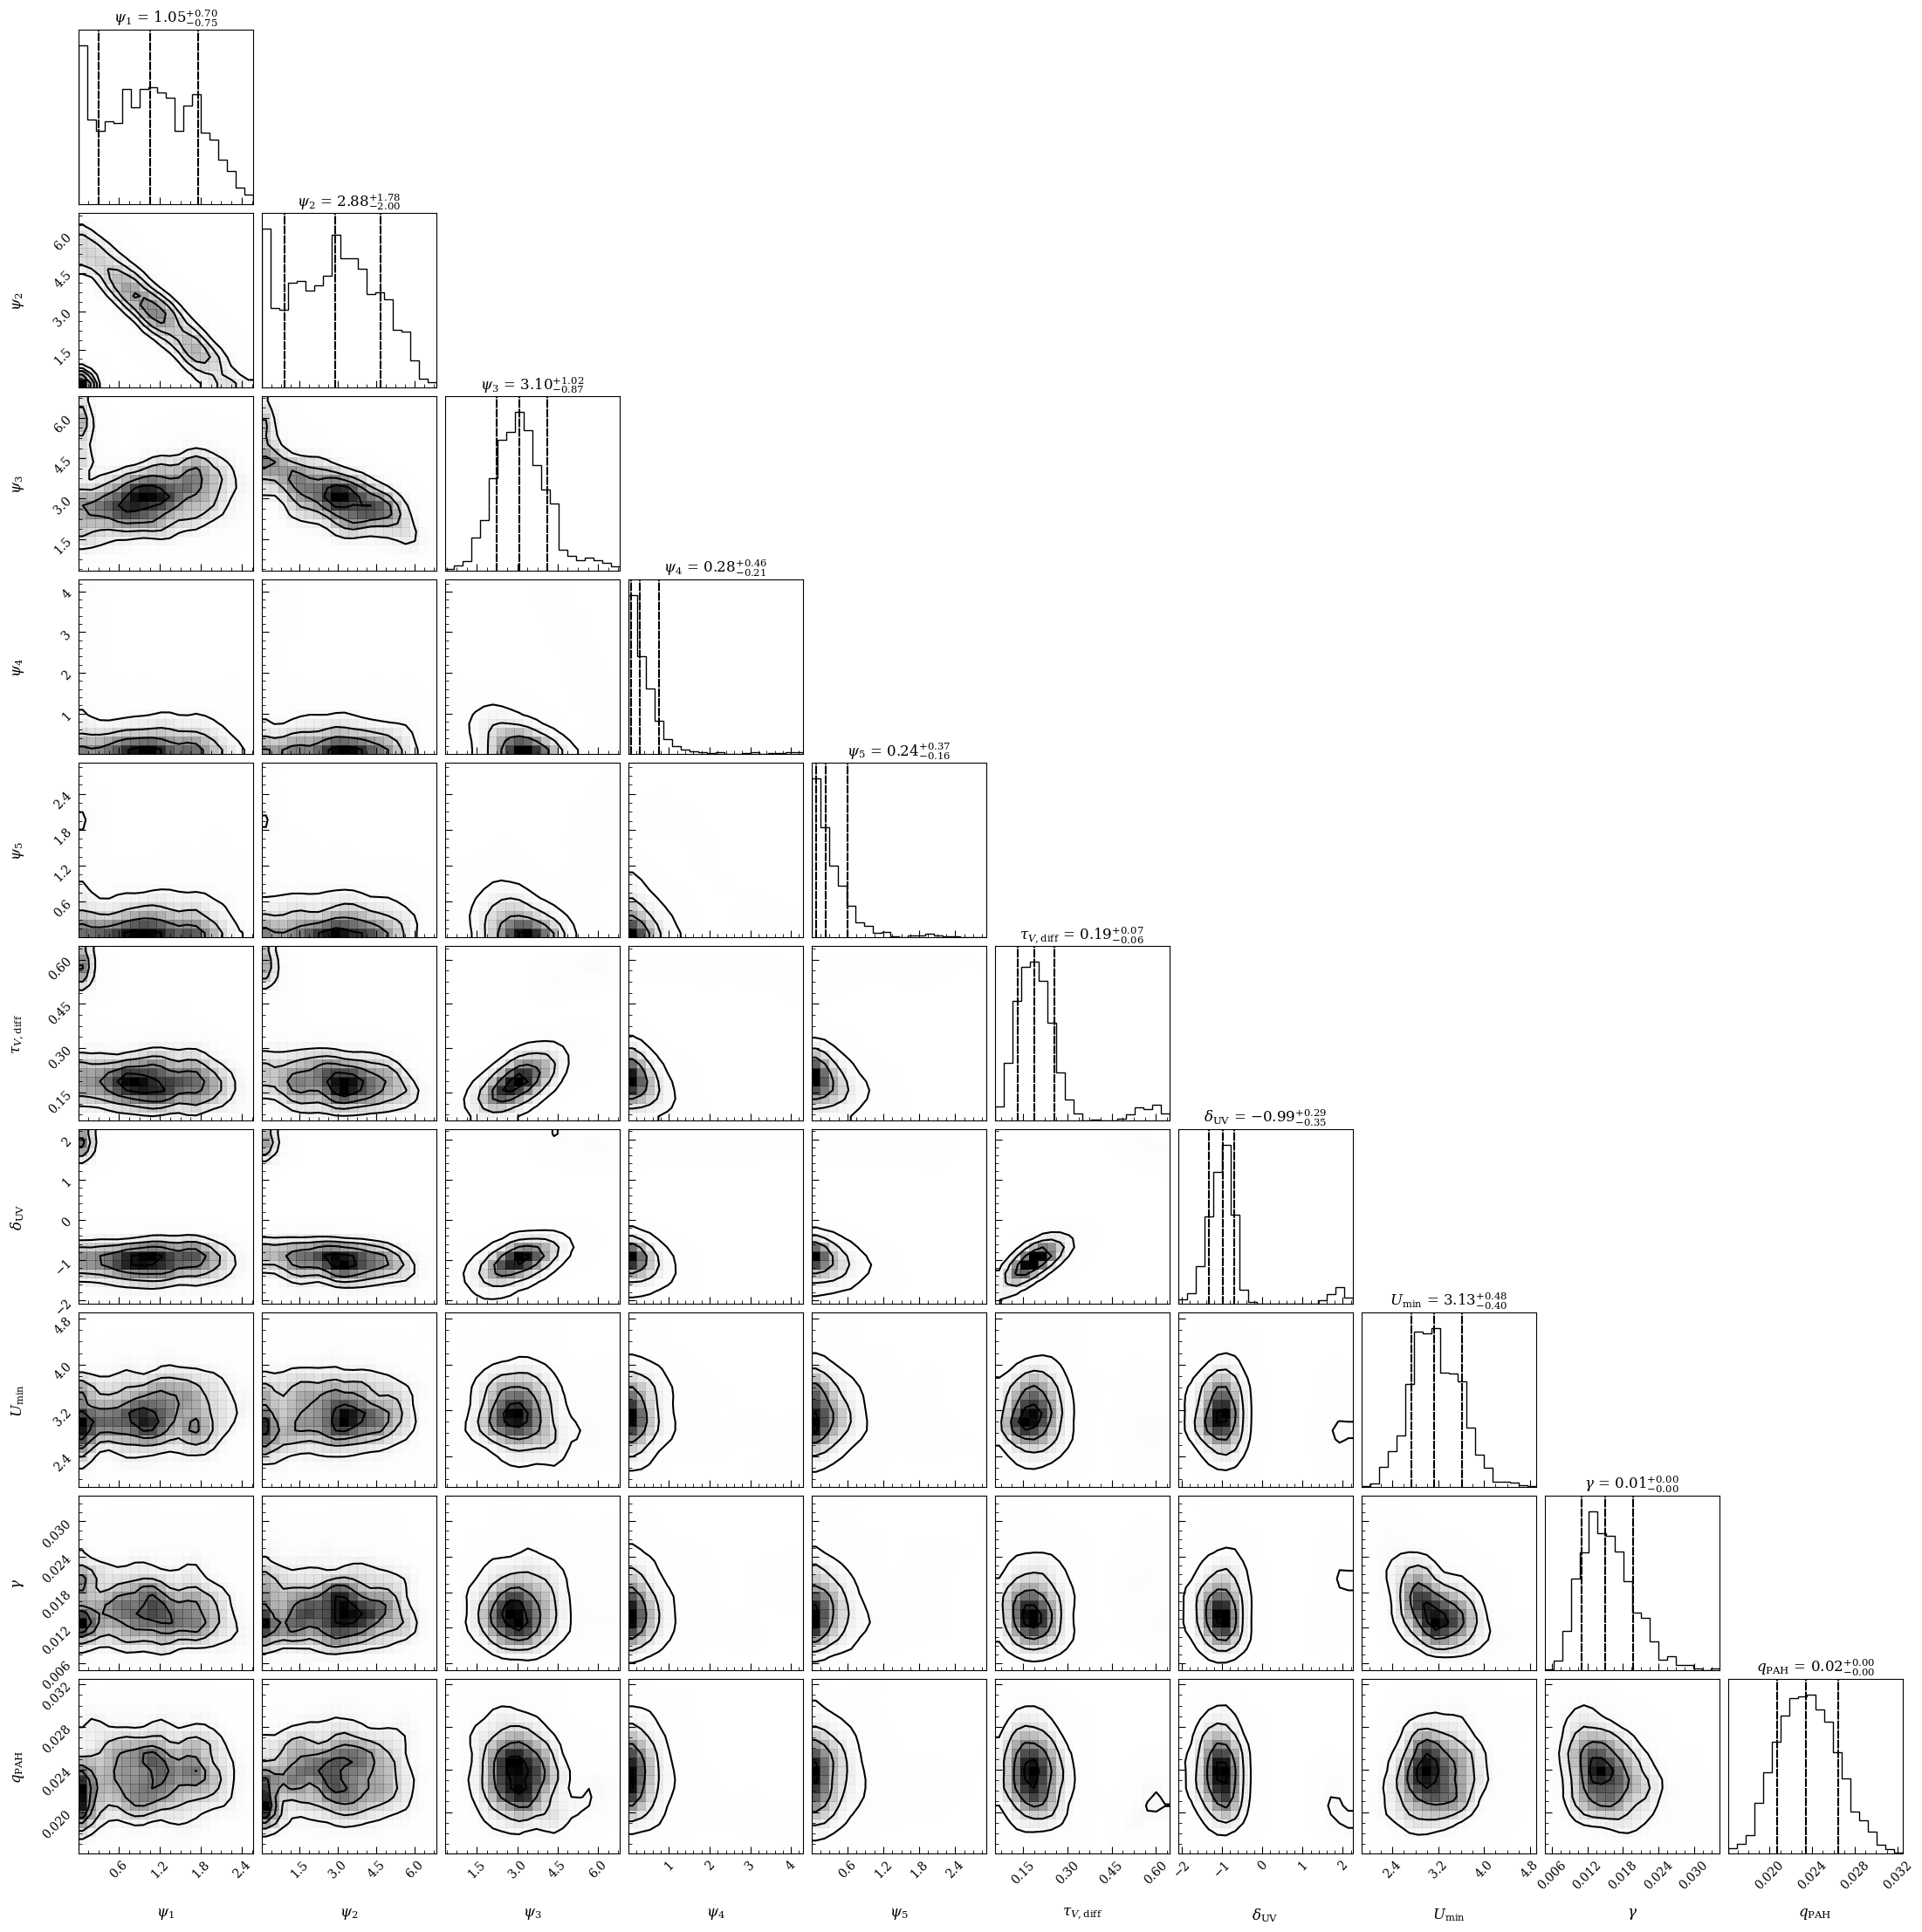

In [34]:
# from lightning.plots import corner_plot

# fig = corner_plot(l, param_arr, 
#                   quantiles=(0.16, 0.50, 0.84),
#                   smooth=1,
#                   levels=None,
#                   show_titles=True)

fig = l.corner_plot(chain, 
                    quantiles=(0.16, 0.50, 0.84),
                    smooth=1,
                    levels=None,
                    show_titles=True)

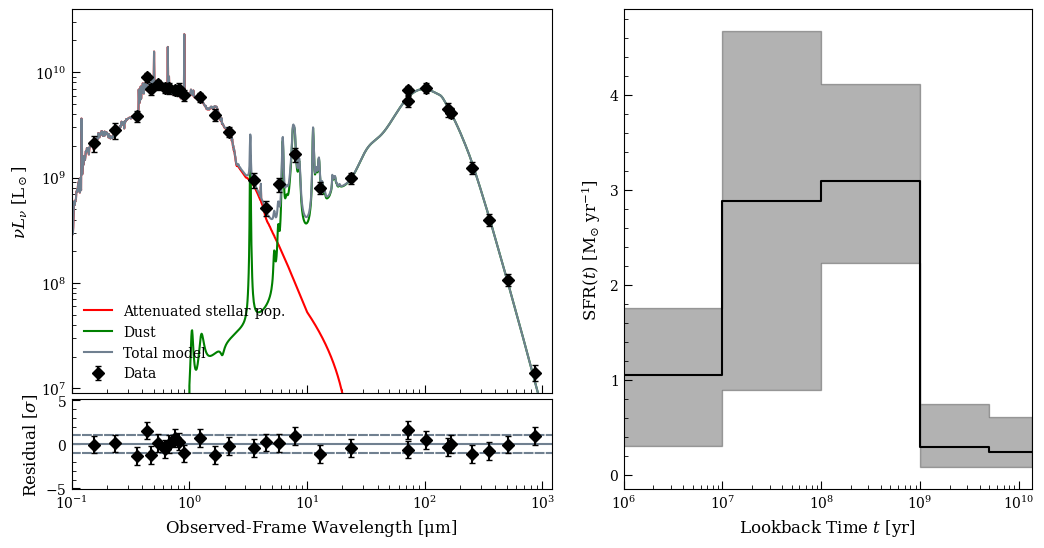

In [35]:
# from lightning.plots import sed_plot_bestfit, sed_plot_delchi, sfh_plot

# We could use the builtin plotting functions to make individual figures...
# fig1, ax1 = sed_plot_bestfit(l, param_arr, logprob_chain, plot_components=True)
# fig2, ax2 = sed_plot_delchi(l, param_arr, logprob_chain)
# fig3, ax3 = sfh_plot(l, param_arr)

# Or we can use them to make a complex (hopefully) publication quality 
# figure by laying out our axes and then using the `ax` keyword in each function:
fig4 = plt.figure(figsize=(12,6))
ax41 = fig4.add_axes([0.1, 0.26, 0.4, 0.64])
ax42 = fig4.add_axes([0.1, 0.1, 0.4, 0.15])
ax43 = fig4.add_axes([0.56, 0.1, 0.34, 0.8])

# fig4, ax41 = sed_plot_bestfit(l, param_arr, logprob_chain,
#                               plot_components=True,
#                               ax=ax41,
#                               legend_kwargs={'loc': 'lower left', 'frameon': False})
# ax41.set_xticklabels([])
# fig4, ax42 = sed_plot_delchi(l, param_arr, logprob_chain, ax=ax42)
# fig4, ax43 = sfh_plot(l, param_arr, ax=ax43)

fig4, ax41 = l.sed_plot_bestfit(chain, logprob_chain,
                                plot_components=True,
                                ax=ax41,
                                legend_kwargs={'loc': 'lower left', 'frameon': False})
ax41.set_xticklabels([])
fig4, ax42 = l.sed_plot_delchi(chain, logprob_chain, ax=ax42)
fig4, ax43 = l.sfh_plot(chain, ax=ax43)

### Goodness of Fit

p = 0.017


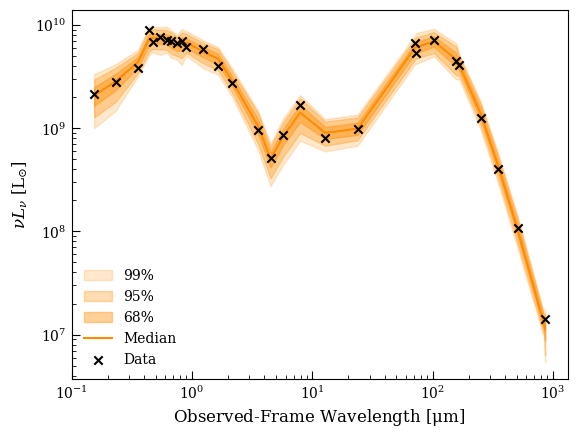

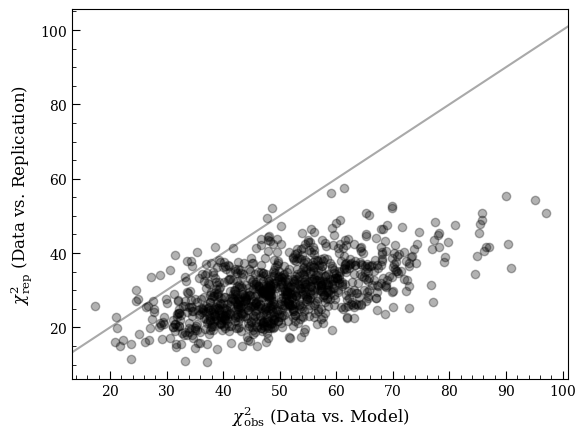

In [32]:
from lightning.ppc import ppc, ppc_sed

# I'm not thrilled about the way this works;
# the PPC needs all the parameters, even the constant
# ones. It's probably past time to make the MCMC fit function
# return a more user-friendly data structure that includes the
# constant values.
# param_arr = np.zeros((chain.shape[0], l.Nparams))
# param_arr[:, const_dim] = p[None, const_dim]
# param_arr[:, var_dim] = chain
 
pvalue, chi2_rep, chi2_obs = ppc(l, chain,
                                 logprob_chain,
                                 Nrep=1000,
                                 seed=12345)
fig, ax = ppc_sed(l, chain,
                  logprob_chain,
                  Nrep=1000,
                  seed=12345,
                  normalize=False)

fig2, ax2 = plt.subplots()

ax2.scatter(chi2_obs,
            chi2_rep,
            marker='o',
            alpha=0.3)

xlim = ax2.get_xlim()
ax2.plot(xlim, xlim, linestyle='-', color='darkgray', zorder=-1)
ax2.set_xlim(xlim)

ax2.set_xlabel(r'$\chi_{\rm obs}^2$ (Data vs. Model)')
ax2.set_ylabel(r'$\chi_{\rm rep}^2$ (Data vs. Replication)')


print('p = %.3f' % (pvalue))

Not a great result from the PPC, but we can see from the SED plot that it seems mostly due to a single $B-$band point (see also the $\delta \chi$ residual plot above), and that the model is *generally* flexible enough to reproduce the data.